## Pure Nash Hausman Test

やること
- サンプルデータの生成
- PN推定量とRobust推定量を得る
- ハウスマン統計量の計算

In [ ]:
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
% matplotlib inline
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from numpy.linalg import inv

def mne(x, mu,delta,random, a):
    prob_x = 1 + (mu + x[1])/delta
    prob_y = 1 + (mu+x[0])/delta
    probs = np.cumsum([prob_x*prob_y, (1-prob_x)*prob_y, prob_x*(1-prob_y), (1-prob_x)*(1-prob_y)])
    prob = a.rvs(1, random_state = random)
    ind = np.searchsorted(probs, prob)
    if ind == 0:
        return [0,0,0]
    elif ind == 1:
        return [1,0,2]
    elif ind == 2:
        return [0,1,1]
    else:
        return [1,1,3]

def nash(x, true_mu, true_delta, random, a):
    if x[0] < -true_mu:
        if x[1] < -true_mu:
            return [0,0,0]
        else :
            return [0,1,1]
    elif -true_mu < x[0] < -true_mu -true_delta:
        if x[1] < -true_mu:
            return [1,0,2]
        elif -true_mu < x[1] < -true_mu -true_delta:
            return mne(x, true_mu,true_delta, random, a)
        else:
            return [0,1,1]
    else:
        if x[1] < -true_mu -true_delta:
            return [1,0,2]
        else:
            return [1,1,3]

サンプルデータ

MマーケットT期分

各市場の人口、プレイヤーごとの距離の三つの変数

$\mu_1 = \beta_1 Pop + \beta_2 Dist_1 + \epsilon_1$

$\mu_2 = \beta_1 Pop + \beta_3 Dist_2 + \epsilon_2$

In [26]:
e = st.uniform()
M = 10000
T = 1000
beta1 = 5
beta2 = -2
beta3 = -2
delta = -1

# M市場分のデータを作る。
data = e.rvs(size = (M,3), random_state = 101)

In [16]:
# T期分の均衡を計算していく
a = st.uniform()
s = st.norm()
random = 101

eps = s.rvs(size = (M,T,2), random_state = 18)

In [17]:
data2 = np.ones((M,T,3))
for m in range(M):
    for t in range(T):
        data2[m, t, :] = nash(eps[m, t, :], data[m, 0]*beta1 + data[m, 1]*beta2, delta, random, a)

市場ごとに結果をdataに入れる

In [24]:
def diff(p):
    p_0 = sum([True for i in data2[p, :, 2] if i == 0.0])/T
    p_2 = sum([True for i in data2[p, :, 2] if i == 3.0])/T
    return p_0 - p_2

d = np.array([diff(p) for p in range(M)])

In [27]:
np.mean(d)

-0.35785249999999996

In [28]:
df = pd.DataFrame({"Pop" : data[:,0], "Dist1" : data[:, 1], "Dist2" : data[:, 2], "diff" : d})

In [29]:
df.head()

,Dist1,Dist2,Pop,diff
0,0.570668,0.028474,0.516399,-0.457
1,0.685277,0.833897,0.171522,0.506
2,0.893613,0.721544,0.306966,0.355
3,0.554228,0.352132,0.189939,0.295
4,0.785602,0.965483,0.181892,0.573


In [30]:
# こいつだけbet1 = 5
# こいつだけuniformから乱数発生
df.to_csv("robust.csv")

deltaの収束が弱いので、データを正規分布から発生させる。

あと、bresnahan 推定量のために市場ごとの参入企業者数の頻度もデータとして出すようにする。

In [12]:
e = st.norm()
M = 10000
T = 1000
beta1 = 3
beta2 = -2
beta3 = -2
delta = -1

# M市場分のデータを作る。
data = e.rvs(size = (M,3), random_state = 101)
# T期分の均衡を計算していく
a = st.uniform()
s = st.norm()
random = 101

eps = s.rvs(size = (M,T,2), random_state = 18)
data2 = np.ones((M,T,3))
for m in range(M):
    for t in range(T):
        data2[m, t, :] = nash(eps[m, t, :], data[m, 0]*beta1 + data[m, 1]*beta2, delta, random, a)
        
def diff(p):
    p_0 = sum([True for i in data2[p, :, 2] if i == 0.0])/T
    p_2 = sum([True for i in data2[p, :, 2] if i == 3.0])/T
    return p_0 - p_2

def num(p):
    num0 = sum([True for i in data2[p, :, 2] if i == 0.0])
    num2 = sum([True for i in data2[p, :, 2] if i == 3.0])
    num1 = T - num0 - num2
    return num0, num1, num2

d = np.array([diff(p) for p in range(M)])
d2 = np.reshape(np.array([num(p) for p in range(M)]), (M, 3))
df = pd.DataFrame({"Pop" : data[:,0], "Dist1" : data[:, 1], "Dist2" : data[:, 2], "diff" : d, "num0":d2[:, 0], "num1":d2[:, 1], "num2":d2[:, 2]})
df.to_csv("robust_norm.csv")

たぶんこれだと仮定を満たさない市場についても計算しているのでそれを排除する

In [13]:
df = pd.read_csv("robust_norm.csv")

In [17]:
df2 = df[(beta1 * df.Pop + beta2 * df.Dist1 + delta > 0) & (beta1 * df.Pop + beta2 * df.Dist2 + delta > 0)]
df2.to_csv("robust_norm_censored.csv")

もうちょっとうまくやらないといけないくさい

パラメータの値ごとに何パターンか用意するか

In [18]:
# 全体的にパラメータを小さく
e = st.norm()
M = 10000
T = 1000
beta1 = 2
beta2 = -1
beta3 = -1
delta = -0.5

# M市場分のデータを作る。
data = e.rvs(size = (M,3), random_state = 101)
# T期分の均衡を計算していく
a = st.uniform()
s = st.norm()
random = 101

eps = s.rvs(size = (M,T,2), random_state = 18)
data2 = np.ones((M,T,3))
for m in range(M):
    for t in range(T):
        data2[m, t, :] = nash(eps[m, t, :], data[m, 0]*beta1 + data[m, 1]*beta2, delta, random, a)
        
def diff(p):
    p_0 = sum([True for i in data2[p, :, 2] if i == 0.0])/T
    p_2 = sum([True for i in data2[p, :, 2] if i == 3.0])/T
    return p_0 - p_2

def num(p):
    num0 = sum([True for i in data2[p, :, 2] if i == 0.0])
    num2 = sum([True for i in data2[p, :, 2] if i == 3.0])
    num1 = T - num0 - num2
    return num0, num1, num2

d = np.array([diff(p) for p in range(M)])
d2 = np.reshape(np.array([num(p) for p in range(M)]), (M, 3))
df = pd.DataFrame({"Pop" : data[:,0], "Dist1" : data[:, 1], "Dist2" : data[:, 2], "diff" : d, "num0":d2[:, 0], "num1":d2[:, 1], "num2":d2[:, 2]})
df.to_csv("robust_norm_2.csv")
df2 = df[(beta1 * df.Pop + beta2 * df.Dist1 + delta > 0) & (beta1 * df.Pop + beta2 * df.Dist2 + delta > 0)]
df2.to_csv("robust_norm_censored_2.csv")

In [21]:
# popの影響を小さく
e = st.norm()
M = 10000
T = 1000
beta1 = 1
beta2 = -1
beta3 = -1
delta = -0.5

# M市場分のデータを作る。
data = e.rvs(size = (M,3), random_state = 101)
# T期分の均衡を計算していく
a = st.uniform()
s = st.norm()
random = 101

eps = s.rvs(size = (M,T,2), random_state = 18)
data2 = np.ones((M,T,3))
for m in range(M):
    for t in range(T):
        data2[m, t, :] = nash(eps[m, t, :], data[m, 0]*beta1 + data[m, 1]*beta2, delta, random, a)
        
def diff(p):
    p_0 = sum([True for i in data2[p, :, 2] if i == 0.0])/T
    p_2 = sum([True for i in data2[p, :, 2] if i == 3.0])/T
    return p_0 - p_2

def num(p):
    num0 = sum([True for i in data2[p, :, 2] if i == 0.0])
    num2 = sum([True for i in data2[p, :, 2] if i == 3.0])
    num1 = T - num0 - num2
    return num0, num1, num2

d = np.array([diff(p) for p in range(M)])
d2 = np.reshape(np.array([num(p) for p in range(M)]), (M, 3))
df = pd.DataFrame({"Pop" : data[:,0], "Dist1" : data[:, 1], "Dist2" : data[:, 2], "diff" : d, "num0":d2[:, 0], "num1":d2[:, 1], "num2":d2[:, 2]})
df.to_csv("robust_norm_3.csv")
df2 = df[(beta1 * df.Pop + beta2 * df.Dist1 + delta > 0) & (beta1 * df.Pop + beta2 * df.Dist2 + delta > 0)]
df2.to_csv("robust_norm_censored_3.csv")

パラメータはちっちゃいほうがよさそう。

ということでもうちょっとちっちゃくする。

censoredじゃないやつはいらないや

In [24]:
# popの影響を小さく
e = st.norm()
M = 10000
T = 1000
beta1 = 0.8
beta2 = -0.5
beta3 = -0.5
delta = -0.25

# M市場分のデータを作る。
data = e.rvs(size = (M,3), random_state = 101)
# T期分の均衡を計算していく
a = st.uniform()
s = st.norm()
random = 101

eps = s.rvs(size = (M,T,2), random_state = 18)
data2 = np.ones((M,T,3))
for m in range(M):
    for t in range(T):
        data2[m, t, :] = nash(eps[m, t, :], data[m, 0]*beta1 + data[m, 1]*beta2, delta, random, a)
        
def diff(p):
    p_0 = sum([True for i in data2[p, :, 2] if i == 0.0])/T
    p_2 = sum([True for i in data2[p, :, 2] if i == 3.0])/T
    return p_0 - p_2

def num(p):
    num0 = sum([True for i in data2[p, :, 2] if i == 0.0])
    num2 = sum([True for i in data2[p, :, 2] if i == 3.0])
    num1 = T - num0 - num2
    return num0, num1, num2

d = np.array([diff(p) for p in range(M)])
d2 = np.reshape(np.array([num(p) for p in range(M)]), (M, 3))
df = pd.DataFrame({"Pop" : data[:,0], "Dist1" : data[:, 1], "Dist2" : data[:, 2], "diff" : d, "num0":d2[:, 0], "num1":d2[:, 1], "num2":d2[:, 2]})
#df.to_csv("robust_norm_4.csv")
df2 = df[(beta1 * df.Pop + beta2 * df.Dist1 + delta > 0) & (beta1 * df.Pop + beta2 * df.Dist2 + delta > 0)]
df2.to_csv("robust_norm_censored_4.csv")

KeyboardInterrupt: 

In [25]:
df2.to_csv("robust_norm_censored_4.csv")

微分してくれるやつを使う

Running unit tests and doctests for numdifftools
NumPy version 1.11.3
NumPy relaxed strides checking option: False
NumPy is installed in /Users/susu/anaconda/lib/python3.5/site-packages/numpy
Python version 3.5.1 |Anaconda custom (x86_64)| (default, Jun 15 2016, 16:14:02) [GCC 4.2.1 Compatible Apple LLVM 4.2 (clang-425.0.28)]
nose version 1.3.7


nose.plugins.cover: ERROR: Coverage not available: unable to import coverage module
.....F............./Users/susu/anaconda/lib/python3.5/site-packages/algopy/utpm/utpm.py:1825: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  S = numpy.zeros((N,M), dtype=x.dtype)
/Users/susu/anaconda/lib/python3.5/site-packages/algopy/utpm/utpm.py:1825: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  S = numpy.zeros((N,M), dtype=x.dtype)
./Users/susu/anaconda/lib/python3.5/site-packages/algopy/globalfuncs.py:189: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  tmp = numpy.zeros((D,P) + shape ,dtype = dtype.data.dtype)
/Users/susu/anaconda/lib/python3.5/site-packages/algopy/globalfuncs.py:189: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the futu

Testing docstrings in /Users/susu/anaconda/lib/python3.5/site-packages/nose/case.py
0 cos complex 2 2
0 cos central 2 10
0 cos backward 2 7
0 cos forward 2 7
0 cos complex 3 2
0 cos central 3 9
0 cos backward 3 6
0 cos forward 3 5
0 cos complex 4 2
0 cos central 4 8
0 cos backward 4 4
0 cos forward 4 4
0 cos complex 5 2
0 cos central 5 6
0 cos backward 5 3
0 cos forward 5 2
0 cos complex 6 2
0 cos central 6 5
0 cos backward 6 2
0 cos forward 6 2
0 cos complex 7 2
0 cos central 7 4
0 cos backward 7 2
[  1.47701940e-09   3.69254849e-10   9.23137122e-11   2.30784281e-11
   5.76960701e-12   1.44240175e-12   3.60600438e-13   9.01501096e-14]


.EE.......
ERROR: Failure: ImportError (No module named 'hypothesis')
----------------------------------------------------------------------
Traceback (most recent call last):
  File "/Users/susu/anaconda/lib/python3.5/site-packages/nose/failure.py", line 39, in runTest
    raise self.exc_val.with_traceback(self.tb)
  File "/Users/susu/anaconda/lib/python3.5/site-packages/nose/loader.py", line 418, in loadTestsFromName
    addr.filename, addr.module)
  File "/Users/susu/anaconda/lib/python3.5/site-packages/nose/importer.py", line 47, in importFromPath
    return self.importFromDir(dir_path, fqname)
  File "/Users/susu/anaconda/lib/python3.5/site-packages/nose/importer.py", line 94, in importFromDir
    mod = load_module(part_fqname, fh, filename, desc)
  File "/Users/susu/anaconda/lib/python3.5/imp.py", line 234, in load_module
    return load_source(name, filename, file)
  File "/Users/susu/anaconda/lib/python3.5/imp.py", line 172, in load_source
    module = _load(spec)
  File "<froz

<nose.result.TextTestResult run=84 errors=3 failures=2>

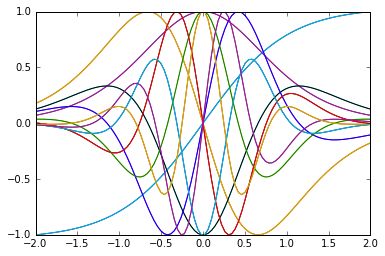

In [2]:
import numdifftools as nd
nd.test(coverage=True, doctests=True)

In [3]:
def rosen(x): return (1-x[0])**2 + 105.*(x[1]-x[0]**2)**2
grad = nd.Gradient(rosen)([1, 1])

In [6]:
H = nd.Hessian(rosen)([1, 1])

In [7]:
H

array([[ 842., -420.],
       [-420.,  210.]])

In [56]:
# 使えそうなので使う
s = st.norm()
df = pd.read_csv("robust_norm_censored_4.csv")
pop = df[["Pop"]].values[:, 0]
dist1 = df[["Dist1"]].values[:, 0]
dist2 = df[["Dist2"]].values[:, 0]
num0 = df[["num0"]].values[:, 0]
num2 = df[["num2"]].values[:, 0]
diff = df[["diff"]].values[:, 0]

# x[0] = beta1, x[1] = beta2, x[2] = delta

def br(x):
    xb1 = x[0] * pop + x[1] * dist1
    xb2 = x[0] * pop + x[1] * dist2
    logl = num0*(np.log(s.cdf(-xb1)*s.cdf(-xb2)) -np.log(1-s.cdf(-xb1)*s.cdf(-xb2)-s.cdf(xb1+x[2])*s.cdf(xb2+x[2]))) \
    + num2*(np.log(s.cdf(xb1+x[2])*s.cdf(xb2+x[2])) - np.log(1-s.cdf(-xb1)*s.cdf(-xb2)-s.cdf(xb1+x[2])*s.cdf(xb2+x[2])))\
    + T*np.log(1-s.cdf(-xb1)*s.cdf(-xb2)-s.cdf(xb1+x[2])*s.cdf(xb2+x[2]))
    return sum(logl)


In [42]:
# brのヘッセ
H_br = nd.Hessian(br)([1, -0.5, -0.25])
inv_H_br = inv(H_br)

/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:15: RuntimeWarning: divide by zero encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:15: RuntimeWarning: invalid value encountered in multiply
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:15: RuntimeWarning: invalid value encountered in add
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:15: RuntimeWarning: invalid value encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/extrapolation.py:443: RuntimeWarning: invalid value encountered in less_equal
  converged = err <= tol
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:150: RuntimeWarning: invalid value encountered in less
  outliers = (((abs(der) < (a_median / trim_fact)) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:151: RuntimeWarning: invalid value encountered in greater
  (abs(der) > (a_median

In [45]:
# brグラディエントとかけざん
# 嘘だわ
# サンプルごとにグラディエントを出して、それを抱えて足していくやつが欲しい。これは足した後にかけてる。
G_br = nd.Gradient(br)([1, -0.5, -0.25])
a = np.matrix(G_br)
np.dot(a.T, a)

/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:15: RuntimeWarning: divide by zero encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:15: RuntimeWarning: invalid value encountered in multiply
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:15: RuntimeWarning: invalid value encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/extrapolation.py:443: RuntimeWarning: invalid value encountered in less_equal
  converged = err <= tol
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:150: RuntimeWarning: invalid value encountered in less
  outliers = (((abs(der) < (a_median / trim_fact)) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:151: RuntimeWarning: invalid value encountered in greater
  (abs(der) > (a_median * trim_fact))) * (a_median > 1e-8) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:152: RuntimeWa

array([-573355.98202355,   18214.03435296, -300417.75135457])

In [92]:
# 正しくはこっち
def br1(x):
    xb1 = x[0] * pop + x[1] * dist1
    xb2 = x[0] * pop + x[1] * dist2
    logl = num0*(np.log(s.cdf(-xb1)*s.cdf(-xb2)) -np.log(1-s.cdf(-xb1)*s.cdf(-xb2)-s.cdf(xb1+x[2])*s.cdf(xb2+x[2]))) \
    + num2*(np.log(s.cdf(xb1+x[2])*s.cdf(xb2+x[2])) - np.log(1-s.cdf(-xb1)*s.cdf(-xb2)-s.cdf(xb1+x[2])*s.cdf(xb2+x[2])))\
    + T*np.log(1-s.cdf(-xb1)*s.cdf(-xb2)-s.cdf(xb1+x[2])*s.cdf(xb2+x[2]))
    return logl

J_br = nd.Jacobian(br1)([1, -0.5, -0.25])
circle1 = np.dot(J_br.T, J_br)

/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:5: RuntimeWarning: divide by zero encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in multiply
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/extrapolation.py:443: RuntimeWarning: invalid value encountered in less_equal
  converged = err <= tol
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:150: RuntimeWarning: invalid value encountered in less
  outliers = (((abs(der) < (a_median / trim_fact)) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:151: RuntimeWarning: invalid value encountered in greater
  (abs(der) > (a_median * trim_fact))) * (a_median > 1e-8) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:152: RuntimeWarni

In [74]:
# Robust推定の方
def robust(x):
    xb1 = x[0] * pop + x[1] * dist1
    xb2 = x[0] * pop + x[1] * dist2
    r = (diff + s.cdf(xb1 + x[2])*s.cdf(xb2 + x[2]) - s.cdf(-xb1)*s.cdf(-xb2))**2
    return -sum(r)

In [75]:
robust([0.8, -0.5, -0.25])

-52.833660912946833

In [60]:
# robustのグラディント
G_rob = nd.Gradient(robust)([1, -0.5, -0.25])
a = np.matrix(G_rob)
np.dot(a.T, a)

matrix([[ 6273297.17490606,  -993192.24083561,  5459486.66070293],
        [ -993192.24083561,   157242.80227022,  -864349.26310292],
        [ 5459486.66070293,  -864349.26310292,  4751248.62849169]])

In [65]:
# BRのnewton raphsonをやっちゃう
def NR(initial, fun, tol, maxit):
    theta = initial
    for i in range(0,maxit):
        G = nd.Gradient(fun)(theta)
        H = nd.Hessian(fun)(theta)
        del_theta = inv(H).dot(G)
        theta = theta - del_theta
        if np.linalg.norm(del_theta) < tol:
            print("NR終わり")
            break
    return theta

In [77]:
# できちゃう
result_br = NR([0.8,-0.5,-0.25], br, 0.005, 10000)

/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:16: RuntimeWarning: divide by zero encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:16: RuntimeWarning: invalid value encountered in multiply
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:16: RuntimeWarning: invalid value encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/extrapolation.py:443: RuntimeWarning: invalid value encountered in less_equal
  converged = err <= tol
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:150: RuntimeWarning: invalid value encountered in less
  outliers = (((abs(der) < (a_median / trim_fact)) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:151: RuntimeWarning: invalid value encountered in greater
  (abs(der) > (a_median * trim_fact))) * (a_median > 1e-8) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:152: RuntimeWa

NR終わり


/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/extrapolation.py:443: RuntimeWarning: invalid value encountered in less_equal
  converged = err <= tol
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:150: RuntimeWarning: invalid value encountered in less
  outliers = (((abs(der) < (a_median / trim_fact)) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:151: RuntimeWarning: invalid value encountered in greater
  (abs(der) > (a_median * trim_fact))) * (a_median > 1e-8) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:152: RuntimeWarning: invalid value encountered in less
  ((der < p25-1.5*iqr) + (p75+1.5*iqr < der)))


In [78]:
# robustも推定してみる
result_rob = NR([0.8,-0.5,-0.25], robust, 0.005, 10000)

NR終わり


推定できたので漸近分散のサンプルアナログを出してみる

In [97]:
def robust1(x):
    xb1 = x[0] * pop + x[1] * dist1
    xb2 = x[0] * pop + x[1] * dist2
    r = diff + s.cdf(xb1 + x[2])*s.cdf(xb2 + x[2]) - s.cdf(-xb1)*s.cdf(-xb2)
    return r

In [99]:
np.matrix(robust1([2,-1,-1])).T

matrix([[ 0.10469566],
        [ 0.25686322],
        [ 0.08053334],
        ..., 
        [ 0.20534389],
        [ 0.11504508],
        [ 0.17500928]])

In [103]:
# パーツを計算
H_br = nd.Hessian(br)(result_br)
inv_H_br = inv(H_br)
tri_1 = -inv_H_br

J_br = nd.Jacobian(br1)(result_br)
circle_1 = np.dot(J_br.T, J_br)

G_rob = nd.Gradient(robust)(result_rob)
a = np.matrix(G_rob)
tri_3 = -np.dot(inv(np.dot(a.T, a)), a.T)

b = np.matrix(robust1(result_rob)).T
circle_3 = np.dot(J_br.T, b)

circle_6 = robust(result_rob)

A_11 = np.dot(np.dot(tri_1, circle_1), tri_1.T)
A_33 = np.dot(np.dot(tri_3, circle_6), tri_3.T)
A_13 = np.dot(np.dot(tri_1, circle_3), tri_3.T)
A_31 = np.dot(np.dot(tri_3, circle_3.T), tri_1.T)

/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:16: RuntimeWarning: divide by zero encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:16: RuntimeWarning: invalid value encountered in multiply
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:16: RuntimeWarning: invalid value encountered in add
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:16: RuntimeWarning: invalid value encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/extrapolation.py:443: RuntimeWarning: invalid value encountered in less_equal
  converged = err <= tol
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:150: RuntimeWarning: invalid value encountered in less
  outliers = (((abs(der) < (a_median / trim_fact)) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:151: RuntimeWarning: invalid value encountered in greater
  (abs(der) > (a_median

In [114]:
# サンプルアナログとるのでMで割ります。
A_11 = A_11 / M
A_33 = A_33 / M
A_13 = A_13 / M
A_31 = A_31 / M

推定値を使ってハウスマン検定をする

In [117]:
# pure test hausman
avar = A_11 - A_13 -A_31 + A_33
gap = np.matrix(result_br - result_rob)
h = M * np.dot(np.dot(gap, inv(avar)), gap.T)

In [118]:
# スーパー棄却できそう
# 自由度はavarの階数らしい。そして階数は2
# chi(2)の有意水準0.5パーセント点は10.6とかなので余裕ですな
h

matrix([[  1.00472075e+12]])

In [122]:
np.rank(avar)

/Users/susu/anaconda/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2699: VisibleDeprecationWarning: `rank` is deprecated; use the `ndim` attribute or function instead. To find the rank of a matrix see `numpy.linalg.matrix_rank`.
  VisibleDeprecationWarning)


2

In [123]:
avar

matrix([[ -5.80224605e+09,  -2.90112303e+09,   1.16044921e+10],
        [ -2.90112303e+09,  -1.45056151e+09,   5.80224605e+09],
        [  1.16044921e+10,   5.80224605e+09,  -2.32089842e+10]])

In [124]:
gap

matrix([[-0.05945773,  0.05827535,  0.08599424]])